# 6-9. 프로젝트: 주식 예측에 도전해보자

ARIMA 모델을 활용해 3가지 주식 종목 가격을 예측해봤다.   

종목은 MSFT (Microsoft Corporation), WMT (Walmart Corporation), LN (Line Corporation) 을 골랐다. MSFT와 WMT의 경우 1970년대부터 미국 증시에 상장해 있던 회사인데, 오래 전 데이터를 포함할 경우 decomposition 과정에서 에러가 발생했다. 따라서 두 회사는 2010년 1월 1일 이후의 주가로 데이터 범위를 한정했다. LN의 경우 미국 증시에 상장한 2016년 7월 14일부터 MAX 데이터를 활용했다.   

ACF, PACF를 그려 p, q를 구하고 차분 안정성을 확인해 d를 구했다. 이 값들을 활용해 ARIMA 모델을 빌드하고 훈련시켜 예측을 진행했다. 그 결과 MAPE 값이 MSFT 9.04%, WMT 3.18%, LN 5.35% 가 나왔다.

## 필요한 모듈 import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## 1. MSFT: Microsoft Corporation (2010-01-01~)

1970년대부터 있던 회사의 경우 MAX로 뽑은 데이터를 집어넣으면 decomposition 과정에서 에러가 발생했다.

### (1) 시계열 데이터 준비

In [2]:
# time series 생성

filepath = os.getenv('HOME') + '/Documents/aiffel_local/20200813/stock_prediction/data/MSFT.csv'
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
df = df[pd.to_datetime("2010-01-01"):]

ts = df['Close'] # 종가만 활용
ts.head()

Date
2010-01-04    30.950001
2010-01-05    30.959999
2010-01-06    30.770000
2010-01-07    30.450001
2010-01-08    30.660000
Name: Close, dtype: float64

### (2) 각종 전처리 수행

In [3]:
# 결측치 확인
ts[ts.isna()]

# 결측치 처리: 없으므로 하지 않음
# ts = ts.interpolate(method='time')
# ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

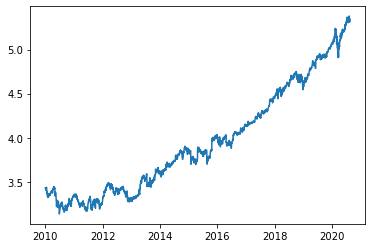

In [4]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### (3) 시계열 안정성 분석

In [5]:
# 함수 정의
## plot_rolling_statistics()
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
## augmented_dickey_fuller_test()
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

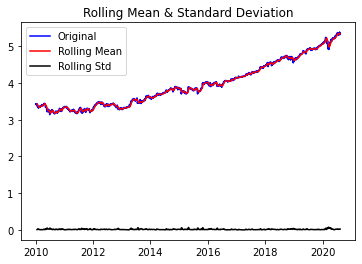

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [7]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    1.636357
p-value                           0.997963
#Lags Used                        9.000000
Number of Observations Used    2661.000000
Critical Value (1%)              -3.432810
Critical Value (5%)              -2.862627
Critical Value (10%)             -2.567349
dtype: float64


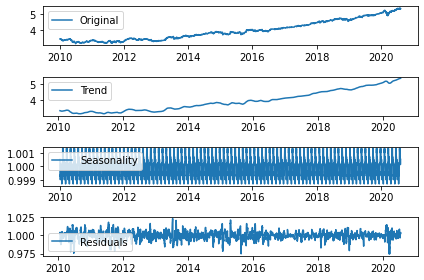

In [8]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

# decomposion은 trend/seasonal/residual 로 나뉨
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [9]:
# residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.459462e+01
p-value                        4.260216e-27
#Lags Used                     2.400000e+01
Number of Observations Used    2.616000e+03
Critical Value (1%)           -3.432852e+00
Critical Value (5%)           -2.862645e+00
Critical Value (10%)          -2.567358e+00
dtype: float64


### (4) 학습, 테스트 데이터셋 생성

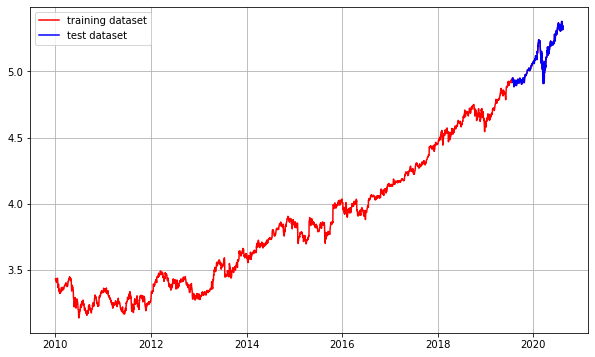

In [10]:
# 학습/테스트 데이터셋 분리 (9:1)
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### (5) 적정 ARIMA 모수 찾기

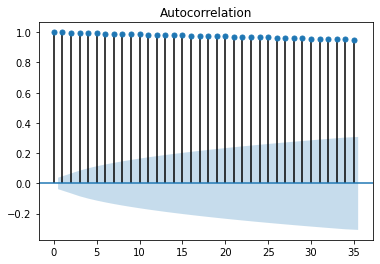

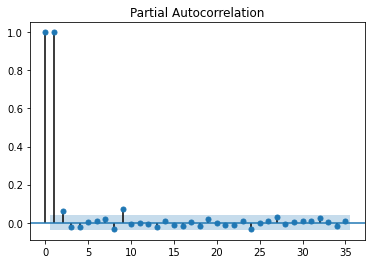

In [11]:
# ACF, PACF 그려보기 -> p, q 구하기
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.881900e+01
p-value                        2.022229e-30
#Lags Used                     8.000000e+00
Number of Observations Used    2.661000e+03
Critical Value (1%)           -3.432810e+00
Critical Value (5%)           -2.862627e+00
Critical Value (10%)          -2.567349e+00
dtype: float64


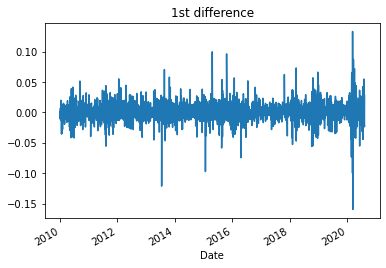

In [12]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="1st difference")

augmented_dickey_fuller_test(diff_1)

# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title="2nd difference")

# augmented_dickey_fuller_test(diff_2)

### (6) ARIMA 모델 훈련과 테스트

In [13]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2402
Model:                 ARIMA(1, 1, 0)   Log Likelihood                6772.177
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 13 Aug 2020   AIC                         -13538.353
Time:                        18:19:10   BIC                         -13521.001
Sample:                             1   HQIC                        -13532.041
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      2.185      0.029    6.41e-05       0.001
ar.L1.D.Close    -0.0317      0.020     -1.557      0.120      -0.072       0.008
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


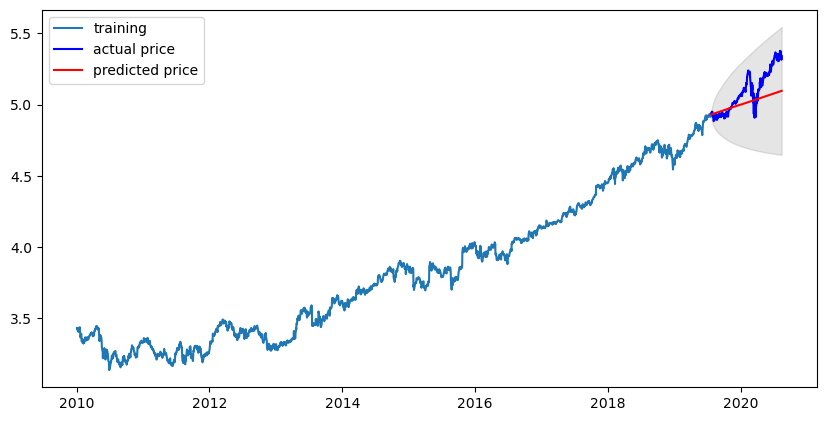

In [14]:
# 모델 테스트 및 플로팅
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [15]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  496.65807160862363
MAE:  16.469892811601035
RMSE:  22.285826697895317
MAPE: 9.04%


## 2. WMT: Walmart Corporation (2010-01-01~)

In [16]:
# time series 생성

filepath = os.getenv('HOME') + '/Documents/aiffel_local/20200813/stock_prediction/data/WMT.csv'
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
df = df[pd.to_datetime("2010-01-01"):]

ts = df['Close'] # 종가만 활용
ts.head()

Date
2010-01-04    54.230000
2010-01-05    53.689999
2010-01-06    53.570000
2010-01-07    53.599998
2010-01-08    53.330002
Name: Close, dtype: float64

### (2) 각종 전처리 수행

In [17]:
# 결측치 확인
ts[ts.isna()]

# 결측치 처리: 없으므로 하지 않음
# ts = ts.interpolate(method='time')
# ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

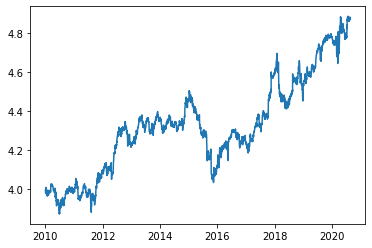

In [18]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### (3) 시계열 안정성 분석

In [19]:
# 함수 정의
## plot_rolling_statistics()
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
## augmented_dickey_fuller_test()
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

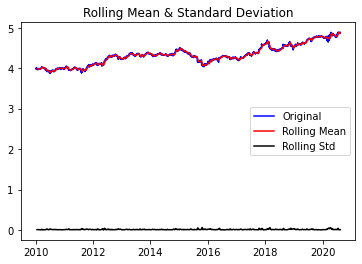

In [20]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [21]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.308395
p-value                           0.924307
#Lags Used                       18.000000
Number of Observations Used    2652.000000
Critical Value (1%)              -3.432818
Critical Value (5%)              -2.862630
Critical Value (10%)             -2.567350
dtype: float64


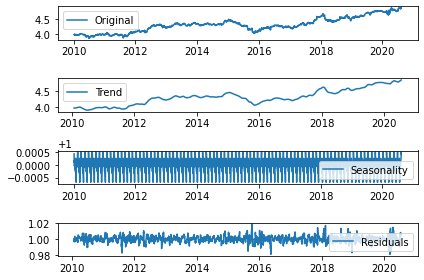

In [22]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

# decomposion은 trend/seasonal/residual 로 나뉨
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [23]:
# residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.398087e+01
p-value                        4.179878e-26
#Lags Used                     2.800000e+01
Number of Observations Used    2.612000e+03
Critical Value (1%)           -3.432856e+00
Critical Value (5%)           -2.862647e+00
Critical Value (10%)          -2.567359e+00
dtype: float64


### (4) 학습, 테스트 데이터셋 생성

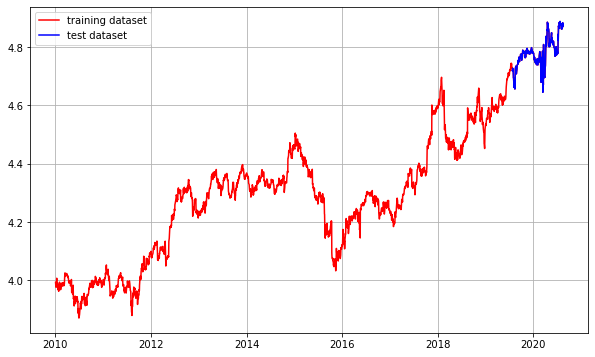

In [24]:
# 학습/테스트 데이터셋 분리 (9:1)
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### (5) 적정 ARIMA 모수 찾기

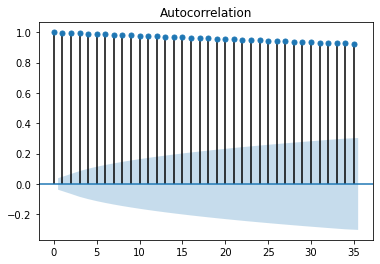

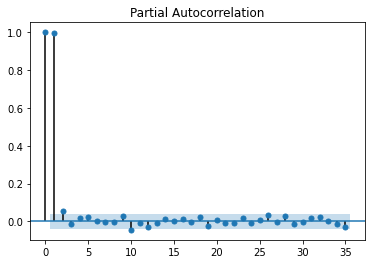

In [25]:
# ACF, PACF 그려보기 -> p, q 구하기
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.253635e+01
p-value                        2.367005e-23
#Lags Used                     1.700000e+01
Number of Observations Used    2.652000e+03
Critical Value (1%)           -3.432818e+00
Critical Value (5%)           -2.862630e+00
Critical Value (10%)          -2.567350e+00
dtype: float64


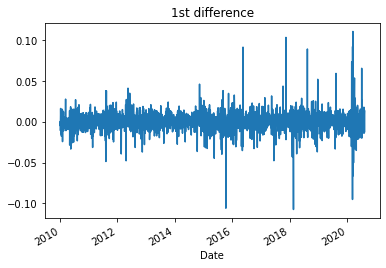

In [26]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="1st difference")

augmented_dickey_fuller_test(diff_1)

# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title="2nd difference")

# augmented_dickey_fuller_test(diff_2)

### (6) ARIMA 모델 훈련과 테스트

In [27]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2402
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7439.396
Method:                       css-mle   S.D. of innovations              0.011
Date:                Thu, 13 Aug 2020   AIC                         -14872.792
Time:                        18:19:35   BIC                         -14855.440
Sample:                             1   HQIC                        -14866.480
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.421      0.155      -0.000       0.001
ar.L1.D.Close    -0.0380      0.020     -1.861      0.063      -0.078       0.002
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


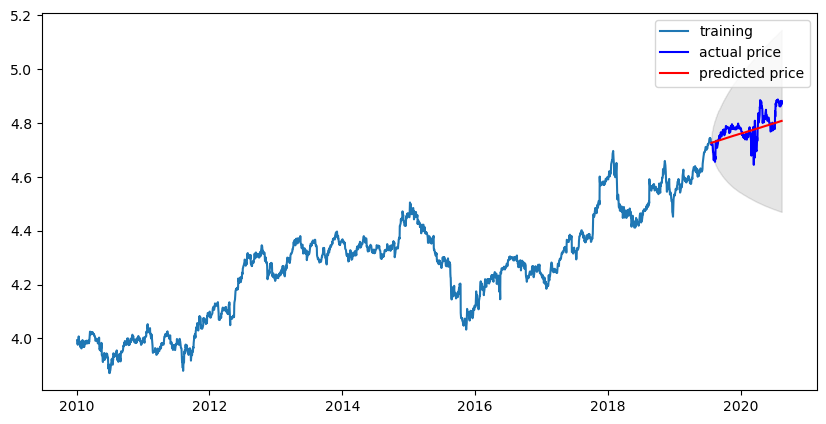

In [28]:
# 모델 테스트 및 플로팅
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [29]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23.378269002039264
MAE:  3.842369854847442
RMSE:  4.835107961776993
MAPE: 3.18%


## 3. LN: Line Corporation (Max, 2016-07-14~)

In [30]:
# time series 생성

filepath = os.getenv('HOME') + '/Documents/aiffel_local/20200813/stock_prediction/data/LN.csv'
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)

ts = df['Close'] # 종가만 활용
ts.head()

Date
2016-07-14    41.580002
2016-07-15    39.650002
2016-07-18    40.650002
2016-07-19    36.529999
2016-07-20    37.599998
Name: Close, dtype: float64

### (2) 각종 전처리 수행

In [31]:
# 결측치 확인
ts[ts.isna()]

# 결측치 처리: 없으므로 하지 않음
# ts = ts.interpolate(method='time')
# ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

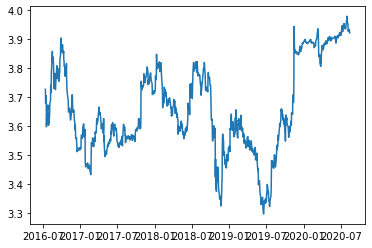

In [32]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### (3) 시계열 안정성 분석

In [33]:
# 함수 정의
## plot_rolling_statistics()
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
## augmented_dickey_fuller_test()
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

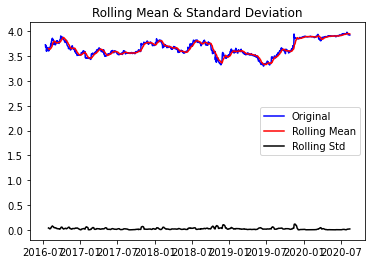

In [34]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [35]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.906857
p-value                           0.328842
#Lags Used                        0.000000
Number of Observations Used    1027.000000
Critical Value (1%)              -3.436733
Critical Value (5%)              -2.864358
Critical Value (10%)             -2.568271
dtype: float64


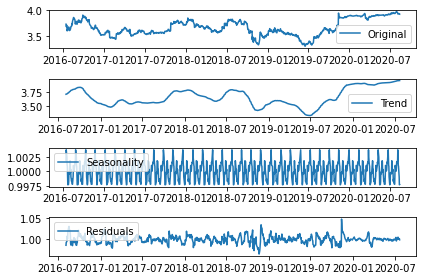

In [36]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

# decomposion은 trend/seasonal/residual 로 나뉨
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
# residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.738345e+00
p-value                        8.628668e-17
#Lags Used                     1.900000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


### (4) 학습, 테스트 데이터셋 생성

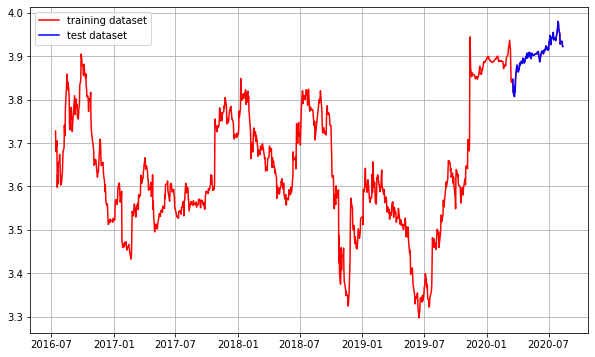

In [38]:
# 학습/테스트 데이터셋 분리 (9:1)
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### (5) 적정 ARIMA 모수 찾기

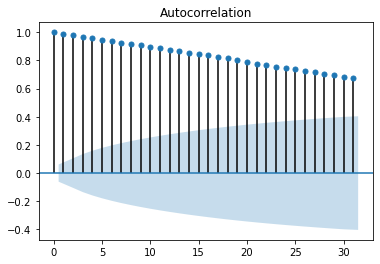

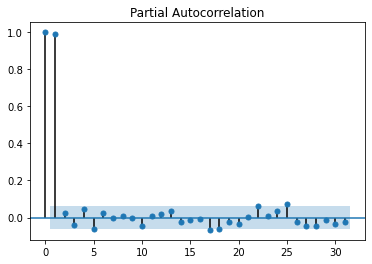

In [39]:
# ACF, PACF 그려보기 -> p, q 구하기
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -32.848009
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1026.000000
Critical Value (1%)              -3.436740
Critical Value (5%)              -2.864361
Critical Value (10%)             -2.568272
dtype: float64


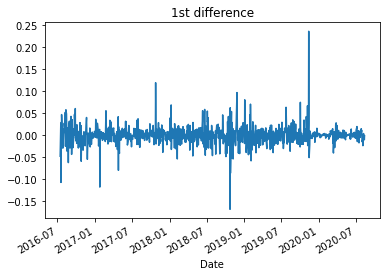

In [40]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="1st difference")

augmented_dickey_fuller_test(diff_1)

# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title="2nd difference")

# augmented_dickey_fuller_test(diff_2)

### (6) ARIMA 모델 훈련과 테스트

In [41]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  924
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2197.566
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 13 Aug 2020   AIC                          -4389.132
Time:                        18:19:49   BIC                          -4374.646
Sample:                             1   HQIC                         -4383.606
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0001      0.001      0.181      0.856      -0.001       0.002
ar.L1.D.Close    -0.0239      0.033     -0.726      0.468      -0.089       0.041
                                    Root

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


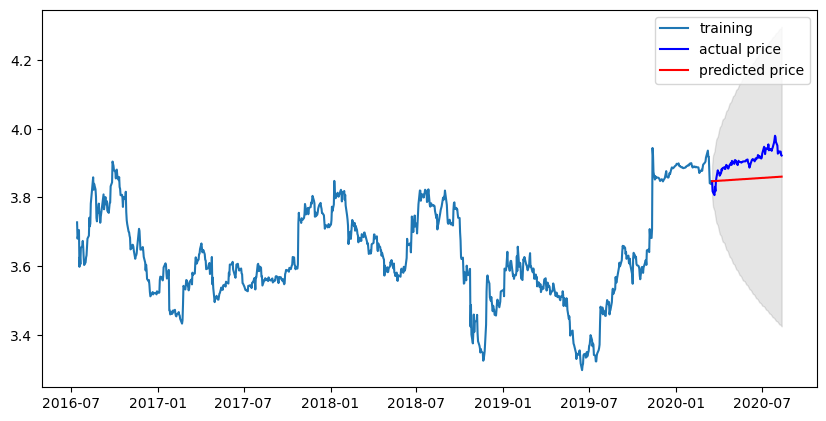

In [42]:
# 모델 테스트 및 플로팅
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [43]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8.595508598997796
MAE:  2.690262549786225
RMSE:  2.931809782199008
MAPE: 5.35%
